# Problem solved implementing dynamic programming 
A small collection of combinatorial optimization problems solved following the dynamic programming principle.
The purpose of the notebook is to teach me and practice dynamic programming. 

Some problems were taken from https://www.geeksforgeeks.org/dynamic-programming/, some problems from P. Brandimarte *From Shortest Paths to Reinforcement Learning: A MATLAB-Based Introduction to Dynamic Programming*, Springer, 2021. The main ideas behind the solutions are taken from the latter book.

In [91]:
import numpy as np
# FIBONACCI
n = 10
states = np.arange(n) # states
values = np.zeros(n, dtype=int) # 
values[0] = 0
values[1] = 1
for t in states[2:]:
    values[t] = values[t-2] + values[t-1]

In [90]:
# CUTTING A ROD 
# find the combination of cuts that maximizes the profit 

rod_length = 10
cut_lengths = np.array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int)
cut_prices = np.array([1, 5, 8, 9, 10, 17, 17, 20], dtype=int)

value_table = np.zeros((rod_length + 1, len(cut_lengths)), dtype=int) # rod_length + 1 to include the maximum rod length as well
decision_table = np.zeros((rod_length + 1, len(cut_lengths)), dtype=int) 

# initialization
decision_table[:, len(cut_lengths)-1] = np.arange(rod_length + 1) // cut_lengths[-1]
value_table = decision_table * cut_prices[len(cut_lengths) - 1] 

# algorithm
for j in np.arange(len(cut_lengths))[-2::-1]: # from last to first cut length, skip last
    for residual_length in np.arange(rod_length + 1): # i: state var: residual capcity
        if residual_length < cut_lengths[j]:
            value_table[residual_length, j] = value_table[residual_length, j+1]
        elif value_table[residual_length, j+1] > value_table[residual_length - cut_lengths[j], j] + cut_prices[j]:
            # il valore allo step precedente è maggiore di quella del passato a cui si è aggiunto l'oggetto corrent
            # update value_table
            value_table[residual_length, j] = value_table[residual_length, j+1]
        else:
            # value_table[residual_length - cut_lengths[j], j] + price >= di quello precedente
            value_table[residual_length, j] = value_table[residual_length - cut_lengths[j], j] + cut_prices[j]
            decision_table[residual_length, j] =+ 1

value_table

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0],
       [ 5,  5,  0,  0,  0,  0,  0,  0],
       [ 8,  8,  8,  0,  0,  0,  0,  0],
       [10, 10,  9,  9,  0,  0,  0,  0],
       [13, 13, 10, 10, 10,  0,  0,  0],
       [17, 17, 17, 17, 17, 17,  0,  0],
       [18, 18, 17, 17, 17, 17, 17,  0],
       [22, 22, 20, 20, 20, 20, 20, 20],
       [25, 25, 25, 20, 20, 20, 20, 20],
       [27, 27, 26, 26, 20, 20, 20, 20]])

In [93]:
number_of_cuts = len(cut_prices)
residual_length = rod_length
optimal_choice = np.zeros(number_of_cuts, dtype=int)

while residual_length >= 0:
    for j in range(number_of_cuts -1):
        if value_table[residual_length, j] > value_table[residual_length, j+1]:
            print(j)
            optimal_choice[j] += 1
            residual_length = residual_length - cut_lengths[j]
    if residual_length == 0:
        break

# check is the solution coincides with that found in the value table
np.dot(optimal_choice, cut_prices)

1
1
5


27

# optimal budget allocation
* we have three possible investments each one with its own continuous profit function.
* find the optimal allocation of the given budget

algorithm intuition
1. Consider a portion b of the budget. b is the state variable.
2. take the investment i and the last investment j.
3. find the maximum profit investing b among i and its residue in j. store this value in the value matrix.

Issues with continuous functions:
* except the first and second investment where we already have function, we need to interpolate the values in `V[t+1]` to find the functions we need.

Such errors cannot be disregarded. we should arrange the data non evenly, with a higher degree of granularity between the 0 and 1

In [95]:
from scipy.optimize import minimize_scalar
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# DATA
profit_functions = [np.sqrt, np.sqrt, np.sqrt]
number_investments = len(profit_functions)
budget = 20
number_grid_points = 50

# INIT
x = np.linspace(0, budget, number_grid_points) # states
V = np.zeros((len(x), len(profit_functions))) # value table
V[:, -1] = np.sqrt(x)

# algorithm
for j in np.arange(number_investments - 1)[::-1]:
    # adesso devo costruire una nuova funzione con cui aggiornare V[j+1]
    # così da incorporare anche i valori pregressi e fare un confronto 1 a 1
    previous_step_profit_function = CubicSpline(x, V[:, j+1])
    current_profit_function = profit_functions[j]
    for i in range(len(x)):
        budget = x[i] # current budget
        objective_function = lambda x: - (current_profit_function(x) + previous_step_profit_function(budget - x))
        res = minimize_scalar(objective_function, bounds=(0, budget))
        V[i, j] = - res.fun

In [96]:
V[-1, 0]

7.7459667609583684

`V[-1, 0]` is the best profit we can get with the optimal budget allocation. Yet, we do not know *how* to actually distribute te budget in the three investment. If I were to print `res.x`, I would find the optimal budget allocation between the two investments for each state of the budget, but this useless. 

What we actually need are the profit functions of `V[:, t]`, `t = 0, 1, 2`. For example, `V[:, 1]` is the best profit for each state of budget result of the maximum of the convex combination of the last investment and the second to last. The next cell shows what I mean

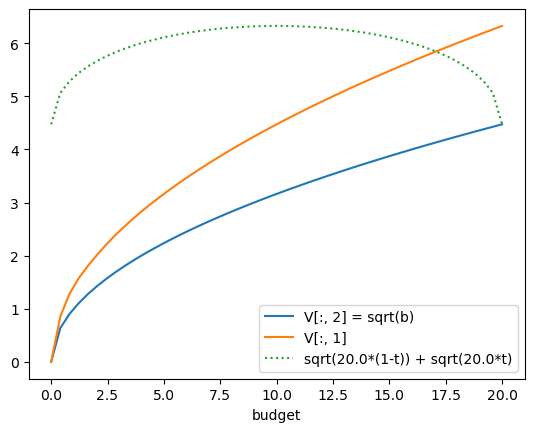

In [107]:
t = np.linspace(0, 1)
b = budget
plt.plot(x, V[:, 2], label="V[:, 2] = sqrt(b)")
plt.plot(x, V[:, 1], label="V[:, 1]")
plt.plot(x, np.sqrt(b*(1-t)) + np.sqrt(b*t), ":", label=f"sqrt({b}*(1-t)) + sqrt({b}*t)")
plt.xlabel("budget")
plt.legend()
plt.show()

The dotted line is the convex combination of two profit functions; its maximum coincides with the maximum of the `V[:, 1]`, that is the plot of the optimal distribution of budget between the two investments for given budget. As expected, the maximum value is an equal distribution of between the two.

To solve actually get a solution, a policy, we need set of splines of the value function over the three investments.

In [85]:
from scipy.optimize import minimize_scalar

profit_functions = [np.sqrt, np.sqrt, np.sqrt]
number_investments = len(profit_functions)
budget = 20
number_grid_points = 50

x = np.linspace(0, budget, number_grid_points) # states
V = np.zeros((len(x), len(profit_functions))) # value table

# init
V[:, -1] = np.sqrt(x)

splines_last_to_first = list()
last_step_value_function = CubicSpline(x, V[:, -1])
splines_last_to_first.append(last_step_value_function)

for j in np.arange(number_investments - 1)[:0:-1]: # skip last profit function
    for i in range(len(x)):
        residual_budget = x[i] # current budget
        objective_function = lambda x: - (profit_functions[j](x) + last_step_value_function(residual_budget - x))
        res = minimize_scalar(objective_function, bounds=(0, residual_budget))
        V[i, j] = - res.fun
    last_step_value_function = CubicSpline(x, V[:, j])
    splines_last_to_first.append(last_step_value_function)
    
splines = list(reversed(splines_last_to_first)) #  reverse the order because we are going to find the best policy in feed forward

In [86]:
# policy computation
budget_distribution = np.zeros(number_investments) # the actual solution
residual_budget = budget
for j in range(number_investments-1):
    objective_function = lambda x: - (profit_functions[j](x) + splines[j](residual_budget - x))
    res = minimize_scalar(objective_function, bounds=(0, residual_budget))
    budget_distribution[j] = res.x
    residual_budget = residual_budget - res.x
budget_distribution[-1] = residual_budget
print(budget_distribution)

[6.66665474 6.66665508 6.66669018]


In [108]:
# check if the found solution is correct
value = 0
for b, f in zip(budget_distribution, profit_functions):
    value += f(b)
value

7.745966692408814

# stochastic inventory control
* demand is descrete and random $D$ -> $V$ is a matrix (no need of splines or other things)
* state variable is the inventory; it has a maximum capacity $I_{max}$
* inventory dynamics: "lost sales": $I_{t+1} = \max(0, I_t + x_t - d_{t+1})$
    1. observe the current inventory $I_t$
    2. take decision: order quantity $x_t$
    3. observe demand $d_{t+1}$. It is reasonable to consider the demand of the following time slot because we cannot observe the today demand
    4. as a consequence, the decision space $X(I_t) = {0, 1, ..., I_{max} - I_t}$
* for the sake of simplicty, the value of the last time slot is null, $F_T(I_T) = 0$
* cost function
    * cost to order $cx_t$
    * accounting costs $\beta(I_t + x_t - d_{t+1})^2$

recursive value function
$$ V_t(I_t) = \min_{x \in X(I_t)} E\left[ cx_t + \beta(I_t + x_t - d_{t+1})^2 + V(I_{t+1}) \right] $$

In [88]:
# DATA
demand_probabilities = np.array([0.1, 0.3, 0.4, 0.1, 0.1])
demand_values = np.array([1, 2, 3, 4, 5])
T = 3 + 1 # plus one so to have times from 0 to T
I_max = 2 + 1 # plus one so to have 0, 1, 2,... I_max otherwise we want consider null capacity
beta = 1
c = 1

# INITIALIZATION
V = np.zeros((I_max, T))
A = np.zeros((I_max, T)) # quantity to order at time t given inventory level i

# algorithm
for t in np.arange(T-1)[::-1]:
    for i in range(I_max):
        min_value = np.inf
        best_order = None
        for x in range(I_max - i):
            v = np.dot(c*x + beta * (i + x - demand_values) ** 2 + V[np.maximum(0, i + x - demand_values), t+1], demand_probabilities)
            if v < min_value:
                min_value = v
                best_order = x
        V[i, t] = min_value
        A[i, t] = best_order

In [89]:
print(V)
print(A)

[[11.2  7.5  3.8  0. ]
 [10.2  6.5  2.8  0. ]
 [ 9.2  5.5  1.8  0. ]]
[[2. 2. 2. 0.]
 [1. 1. 1. 0.]
 [0. 0. 0. 0.]]
